# FTML Project Exercice 6

### Dataset presentation and problem statement

Automatic fish species classification from underwater images is a computer vision task with real-world applications in marine conservation and industrial automation. This supervised learning problem consists of identifying the species of a fish based on its visual features in a low-resolution image (resized to 32×32 pixels). Accurate classification models can be used aboard fishing vessels to automate sorting by species, for example, to direct catches to the appropriate storage or freezing processes. Such systems can also support conservation efforts by identifying and releasing non-target or protected species in real time, helping ensure compliance with marine biodiversity regulations. We try to solve this problem by using the Fish4Knowledge project, you can find the used data [here](https://homepages.inf.ed.ac.uk/rbf/Fish4Knowledge/GROUNDTRUTH/RECOG/).

The Fish Recognition Ground-Truth dataset, developed under the Fish4Knowledge project, includes 27,370 manually labeled fish images organized into 23 species-based groups. These images are extracted from underwater video footage using specialized detection and tracking software and verified with guidance from marine biologists. Each species is stored in a separate archive containing the corresponding fish images and binary masks, with filenames reflecting unique tracking and fish identifiers. The dataset is notably imbalanced, with certain species represented by thousands of images and others by just a few dozen.

You can find all the data in the data/ folder, and here is the correspondence between directories names and species:

| ID.species                   | Detection | Trajectory |
|-----------------------------|-------------|--------------|
| 01.Dascyllus reticulatus    | 12112       | 4240         |
| 02.Plectroglyphidodon dickii| 2683        | 1225         |
| 03.Chromis chrysura         | 3593        | 1175         |
| 04.Amphiprion clarkii       | 4049        | 1021         |
| 05.Chaetodon lunulatus      | 2534        | 536          |
| 06.Chaetodon trifascialis   | 190         | 79           |
| 07.Myripristis kuntee       | 450         | 71           |
| 08.Acanthurus nigrofuscus   | 218         | 71           |
| 09.Hemigymnus fasciatus     | 241         | 58           |
| 10.Neoniphon sammara        | 299         | 53           |
| 11.Abudefduf vaigiensis     | 98          | 42           |
| 12.Canthigaster valentini   | 147         | 28           |
| 13.Pomacentrus moluccensis  | 181         | 27           |
| 14.Zebrasoma scopas         | 90          | 23           |
| 15.Hemigymnus melapterus    | 42          | 16           |
| 16.Lutjanus fulvus          | 206         | 15           |
| 17.Scolopsis bilineata      | 49          | 8            |
| 18.Scaridae                 | 56          | 5            |
| 19.Pempheris vanicolensis   | 29          | 6            |
| 20.Zanclus cornutus         | 21          | 6            |
| 21.Neoglyphidodon nigroris | 16          | 8            |
| 22.Balistapus undulatus     | 41          | 6            |
| 23.Siganus fuscescens       | 25          | 6            |

Each picture filename follow the format: `fish_tracking-id_fish-id.png`. You can have multiple pictures of the same fish: in this case, the tracking-id of the two pictures will be the same.

In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def process_image(file_path: Path, label: int, image_size=(32, 32), normalize=True):
    try:
        img = cv2.imread(str(file_path))
        if img is None:
            raise ValueError("Image loading failed.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
        if normalize:
            img = img.astype(np.float32) / 255.0
        return {"image": img, "label": label}
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_images_parallel(data_dir: str, image_size=(32, 32), normalize=True, max_workers=8):
    data_dir = Path(data_dir)
    tasks = []

    # Prepare all file paths and labels first
    for class_index in range(1, 24):
        folder_name = f"fish_{class_index:02d}"
        folder_path = data_dir / folder_name
        label = class_index - 1

        if not folder_path.exists():
            continue

        for file in os.listdir(folder_path):
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                file_path = folder_path / file
                tasks.append((file_path, label))

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_image, path, label, image_size, normalize) for path, label in tasks]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading images"):
            result = future.result()
            if result:
                results.append(result)

    df = pd.DataFrame(results)
    return df

def split_dataset(df: pd.DataFrame, test_size=0.2, random_state=42):
    return train_test_split(df, test_size=test_size, stratify=df["label"], random_state=random_state)

In [3]:
from sklearn.model_selection import train_test_split

df = load_images_parallel("/kaggle/input/fish-zip/", image_size=(32, 32), normalize=True, max_workers=16)

X = np.stack(df["image"].values)  # shape (N, 32, 32, 3)
y = df["label"].values

# Flatten images for classical ML
X_flat = X.reshape((X.shape[0], -1))

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)

Loading images: 100%|██████████| 27370/27370 [00:24<00:00, 1128.82it/s]


The code above preprocesses a fish image dataset by loading images from 23 class folders named `fish_01` to `fish_23`. Each image is read in parallel using a thread pool to speed up processing. The images are converted from BGR to RGB color space, resized to 32x32 pixels (mainly for performance purposes), and normalized to have pixel values between 0 and 1. Successfully processed images and their corresponding class labels are collected into a pandas DataFrame. Finally, the dataset is split into training and testing sets with stratified sampling to maintain class balance.

### Data presentation

To present the data, we will show the distribution of each class and display a sample example from every category.

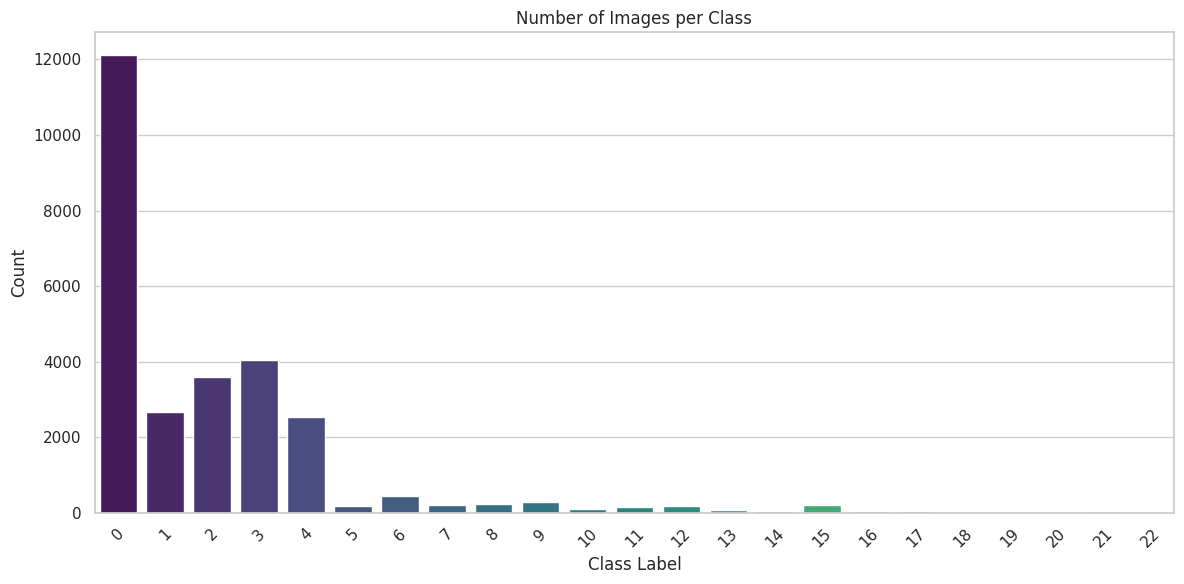

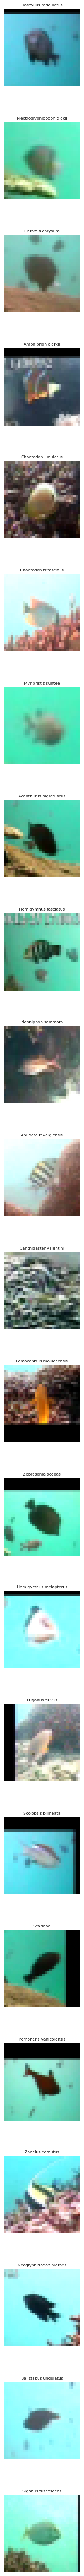

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_class_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(x="label", data=df, palette="viridis")
    plt.title("Number of Images per Class")
    plt.xlabel("Class Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

species_names = [
    "Dascyllus reticulatus",
    "Plectroglyphidodon dickii",
    "Chromis chrysura",
    "Amphiprion clarkii",
    "Chaetodon lunulatus",
    "Chaetodon trifascialis",
    "Myripristis kuntee",
    "Acanthurus nigrofuscus",
    "Hemigymnus fasciatus",
    "Neoniphon sammara",
    "Abudefduf vaigiensis",
    "Canthigaster valentini",
    "Pomacentrus moluccensis",
    "Zebrasoma scopas",
    "Hemigymnus melapterus",
    "Lutjanus fulvus",
    "Scolopsis bilineata",
    "Scaridae",
    "Pempheris vanicolensis",
    "Zanclus cornutus",
    "Neoglyphidodon nigroris",
    "Balistapus undulatus",
    "Siganus fuscescens"
]

def show_sample_images(df, num_classes=23, samples_per_class=1):
    plt.figure(figsize=(samples_per_class * 2.5, num_classes * 2.5))
    
    for class_idx in range(num_classes):
        class_images = df[df["label"] == class_idx].sample(
            n=min(samples_per_class, len(df[df["label"] == class_idx])), random_state=42
        )
        for i, row in enumerate(class_images.itertuples()):
            plt_idx = class_idx * samples_per_class + i + 1
            plt.subplot(num_classes, samples_per_class, plt_idx)
            plt.imshow(row.image)
            plt.axis("off")
            if samples_per_class == 1:
                plt.title(species_names[class_idx], fontsize=8)
            else:
                if i == 0:
                    plt.title(species_names[class_idx], fontsize=8)
    
    plt.tight_layout()
    plt.subplots_adjust(top=1.25)
    plt.show()

plot_class_distribution(df)
show_sample_images(df)

### Model selection and optimization

The following code implements a hyperparameter optimization framework using Optuna to identify the best classification model and its optimal hyperparameters among four candidates: Random Forest, XGBoost, CatBoost, and a ResNet-18 based deep learning model. These specific models were chosen to have a diverse range of classification approaches: traditional machine learning techniques with Random Forest, XGBoost, and CatBoost (that will allow to perform strongly on categories that have a small support), and deep convolutional neural network architecture Resnet18, that is tailored for image classification.

Due to limited computational resources, we did hyperparameter optimization within a restricted parameter range and selected only four models for comparison. We used kaggle GPUs to go faster.

In [20]:
import optuna
import numpy as np
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import TensorDataset, DataLoader

# === For ResNet: reshape and convert ===
X_train_img = X_train.reshape(-1, 3, 32, 32).astype(np.float32)
X_val_img = X_val.reshape(-1, 3, 32, 32).astype(np.float32)

X_train_tensor = torch.tensor(X_train_img)
X_val_tensor = torch.tensor(X_val_img)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)

# === Objective function for Optuna ===
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["RandomForest", "XGBoost", "CatBoost", "ResNet"])

    if classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("rf_n_estimators", 50, 200)
        max_depth = trial.suggest_int("rf_max_depth", 5, 20)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        acc = accuracy_score(y_val, preds)

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("xgb_n_estimators", 50, 200)
        max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
        learning_rate = trial.suggest_float("xgb_learning_rate", 0.05, 0.3)
        clf = XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            random_state=42,
            verbosity=0,
            n_jobs=-1
        )
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        acc = accuracy_score(y_val, preds)

    elif classifier_name == "CatBoost":
        n_estimators = trial.suggest_int("cat_n_estimators", 50, 200)
        depth = trial.suggest_int("cat_depth", 4, 8)
        learning_rate = trial.suggest_float("cat_learning_rate", 0.05, 0.3)
        clf = CatBoostClassifier(
            iterations=n_estimators,
            depth=depth,
            learning_rate=learning_rate,
            task_type="GPU",
            devices="0",
            verbose=0,
            random_seed=42
        )
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        acc = accuracy_score(y_val, preds)

    else:  # ResNet
        num_classes = 23
        model = models.resnet18(weights=None)
        model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model = model.cuda()

        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(3):  # Short for fast optimization
            for xb, yb in train_loader:
                xb, yb = xb.cuda(), yb.cuda()
                optimizer.zero_grad()
                output = model(xb)
                loss = criterion(output, yb)
                loss.backward()
                optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.cuda(), yb.cuda()
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()

        acc = correct / total

    return acc

# === Run Optuna study ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

# === Print best trial ===
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-04 12:29:29,054] A new study created in memory with name: no-name-a387a550-3360-4cc8-b190-21e6b2a56708


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-07-04 12:30:58,165] Trial 0 finished with value: 0.9550602849835587 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 141, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.09062603100696377}. Best is trial 0 with value: 0.9550602849835587.
[I 2025-07-04 12:31:05,862] Trial 1 finished with value: 0.8333942272561199 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 68, 'rf_max_depth': 6}. Best is trial 0 with value: 0.9550602849835587.
[I 2025-07-04 12:33:07,263] Trial 2 finished with value: 0.9638290098648155 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 185, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.1725046879592827}. Best is trial 2 with value: 0.9638290098648155.
[I 2025-07-04 12:34:36,662] Trial 3 finished with value: 0.9662038728534892 and parameters: {'classifier': 'XGBoost', 'xgb_n_estimators': 165, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.24409732368240272}. Best is trial 3 with value: 0.9662038728534892.
[I 2025-07-04 12:35:02,87

To our surprise, XGBoost outperformed other models in the fish species classification. Our explanation is that the dataset has imbalanced and heterogeneous data distributions:the dataset has significant class imbalance, with some species having thousands of samples while others only a few dozen. Tree-based ensemble methods like XGBoost inherently manage such imbalance better by focusing on difficult-to-classify samples through gradient boosting. Additionally XGBoost is advantageous when working with low-resolution images.

We trained a XGBoost model with parameters we got:

In [21]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Rebuild the best model
best_params = study.best_trial.params

clf = XGBClassifier(
    n_estimators=best_params["xgb_n_estimators"],
    max_depth=best_params["xgb_max_depth"],
    learning_rate=best_params["xgb_learning_rate"],
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42,
    verbosity=0,
    n_jobs=-1
)

clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21801963246704248,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
y_pred = clf.predict(X_val)

report = classification_report(y_val, y_pred, digits=4)
print("Classification Report (XGBoost):\n")
print(report)

acc = accuracy_score(y_val, y_pred)
f1_macro = f1_score(y_val, y_pred, average='macro')
f1_weighted = f1_score(y_val, y_pred, average='weighted')
precision_macro = precision_score(y_val, y_pred, average='macro')
recall_macro = recall_score(y_val, y_pred, average='macro')

print("Accuracy              :", round(acc, 4))
print("F1 Score (macro)      :", round(f1_macro, 4))
print("F1 Score (weighted)   :", round(f1_weighted, 4))
print("Precision (macro)     :", round(precision_macro, 4))
print("Recall (macro)        :", round(recall_macro, 4))

Classification Report (XGBoost):

              precision    recall  f1-score   support

           0     0.9626    0.9889    0.9756      2422
           1     0.9630    0.9683    0.9656       537
           2     0.9624    0.9624    0.9624       719
           3     0.9792    0.9877    0.9834       810
           4     0.9881    0.9842    0.9862       507
           5     0.8788    0.7632    0.8169        38
           6     0.9770    0.9444    0.9605        90
           7     0.8750    0.7955    0.8333        44
           8     0.9714    0.7083    0.8193        48
           9     0.9833    0.9833    0.9833        60
          10     1.0000    0.5500    0.7097        20
          11     0.8889    0.8276    0.8571        29
          12     1.0000    0.8056    0.8923        36
          13     1.0000    0.3889    0.5600        18
          14     1.0000    0.2500    0.4000         8
          15     0.9756    0.9756    0.9756        41
          16     0.8889    0.8000    0.8421    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

The XGBoost model achieved strong overall performance on the fish species classification task, with an accuracy of 96.68%. The weighted F1 score, which accounts for class imbalance, was also high at 0.9646, indicating that the model performs well across most species. However, the macro-average F1 score was lower at 0.7798, reflecting that the model struggles more with classes that have fewer samples. Precision remains high across all classes, with a macro-average of 0.878, but recall drops noticeably for smaller classes, with a macro-average of 0.7305, meaning some fish species with limited data are harder for the model to correctly identify.